In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
from PIL import Image
import math

<h3>The image in Fig is a nuclear whole body bone scan, used to detect diseases such as bone infection and tumors. Our objective is to enhance this image by sharpening it and by bringing out more of the skeletal detail. </h3> 

The narrow dynamic range of the intensity levels and high noise content make this image difficult to enhance. The strategy we will follow is to utilize the <b><i>Laplacian</i></b> to highlight fine detail, and the <b><i>gradient</i></b> to enhance prominent edges. For reasons that will be explained shortly, a smoothed version of the gradient image will be used to mask the Laplacian image. Finally, we will attempt to increase the dynamic range of the intensity levels by using an <b><i>intensity transformation</i></b>.

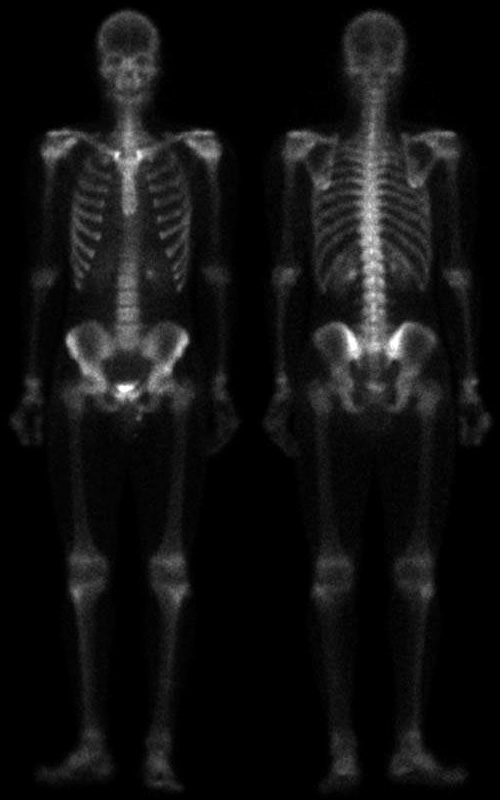

In [2]:
img = Image.open('Fig0343(a)(skeleton_orig).tif')
img

In [3]:
org = np.asarray(img)
org.shape

(800, 500)

<h3>implementation of laplacian second derivatives</h3>

In [4]:
def laplacian(org):
    filterimg = np.zeros(org.shape)
    padimg = np.zeros((org.shape[0]+2, org.shape[1]+2))
    padimg[1:(padimg.shape[0] - 1), 1:(padimg.shape[1] - 1)] = org
    mask = [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]
    for i in range(filterimg.shape[0]):
        for j in range(filterimg.shape[1]):
            portion = padimg[i:i+3, j:j+3]
            filterimg[i][j] = np.sum(np.multiply(mask,portion))
    lapsharp = org + filterimg
    return filterimg,lapsharp

In [5]:
[lapar, lapsharpar] = laplacian(org)

In [6]:
def converttoimage(arr):
    arr = arr.astype(np.uint8)
    fil = Image.fromarray(arr)
    return fil

<h3>Since the array may contain negative values too it is scaled/maped from 0 to 255.</h3>

In [7]:
lapscalear = ((lapar - np.amin(lapar))/(np.amax(lapar) - np.amin(lapar)))*255
lapsharpar[lapsharpar < 0] = 0
lapim = converttoimage(lapscalear)
lapsharpim = converttoimage(lapsharpar)

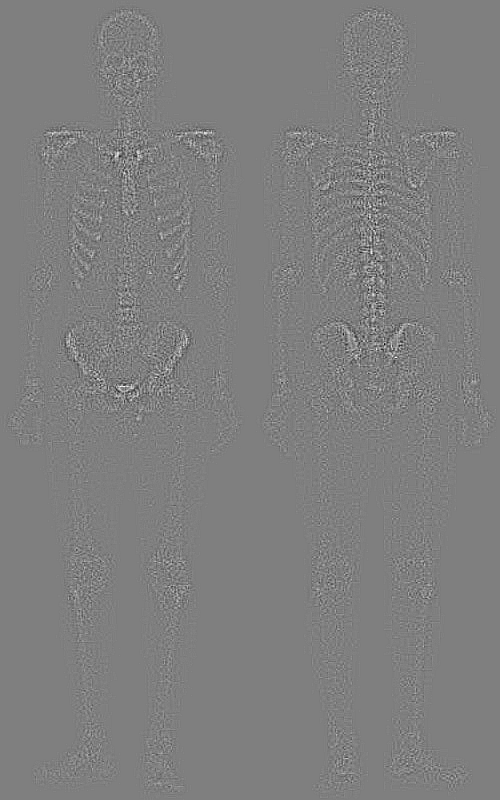

In [49]:
lapim

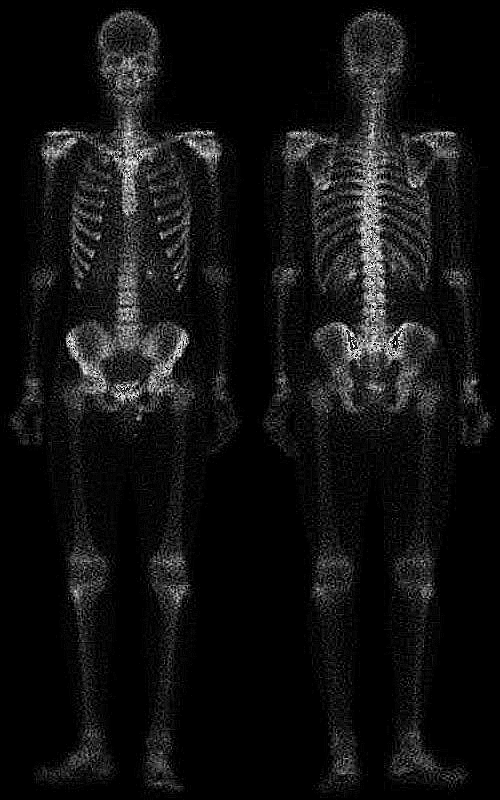

In [47]:
lapsharpim

<h3> Just by inspecting the image we see lots of noise there. One way that comes immediately to our mind to reduce the noise is to use median filter. however, median filtering is a nonlinear process capable of removing image features. Which is definately not acceptable in medial image processing.</h3>

</h2>An alternate approach is to use a mask formed from a smoothed version of the gradient of the original image.The motivation behind this is straightforward and is based on the properties of first- and second-order derivatives. The Laplacian, being a second-order derivative operator, has the definite advantage that it is superior in enhancing fine detail. However, this causes it to produce noisier results than the gradient. This noise is most objectionable in smooth areas, where it tends to be more visible. The gradient has a stronger average response in areas of significant intensity transitions (ramps and steps) than does the Laplacian. The response of the gradient to noise and fine detail is lower than the Laplacian’s and can be lowered further by smoothing the
gradient with an averaging filter.</h2>

In [9]:
def gradient(arr):
    filterimg = np.zeros(arr.shape)
    padimg = np.zeros((arr.shape[0]+2, arr.shape[1]+2))
    padimg[1:(padimg.shape[0] - 1), 1:(padimg.shape[1] - 1)] = arr
    masky = [[-1,-2,-1],[0,0,0],[1,2,1]]
    maskx = [[-1,0,1],[-2,0,2],[-1,0,1]]
    for i in range(filterimg.shape[0]):
        for j in range(filterimg.shape[1]):
            portion = padimg[i:i+3, j:j+3]
            gx = np.sum(np.multiply(maskx, portion))
            gy = np.sum(np.multiply(masky, portion))
            filterimg[i][j] = np.absolute(gx) + np.absolute(gy)
    return filterimg

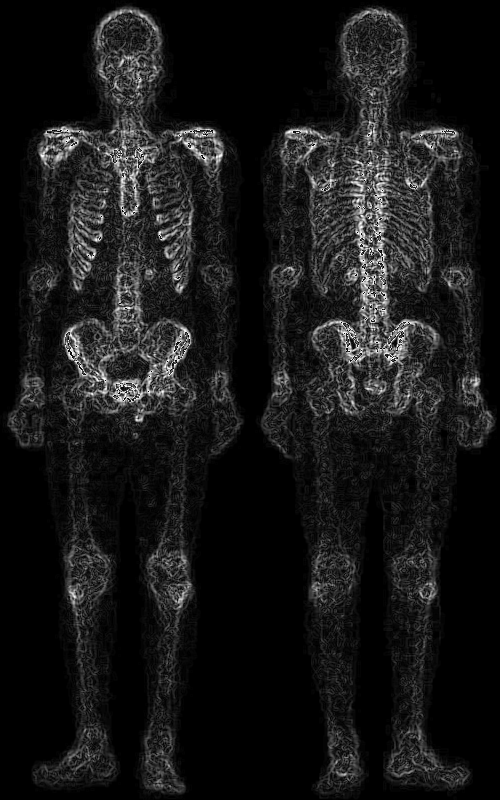

In [10]:
gradar = gradient(org)
gradim = converttoimage(gradar)
gradim

In [11]:
def averagefiltering(arr):
    filterar = np.zeros(arr.shape)
    padimg = np.zeros((arr.shape[0]+4, arr.shape[1]+4))
    padimg[2:(padimg.shape[0]-2), 2:(padimg.shape[1]-2)] = arr
    for i in range(filterar.shape[0]):
        for j in range(filterar.shape[1]):
            portion = padimg[i:i+5,j:j+5]
            filterar[i][j] = np.round(np.sum(portion/25))
    return filterar

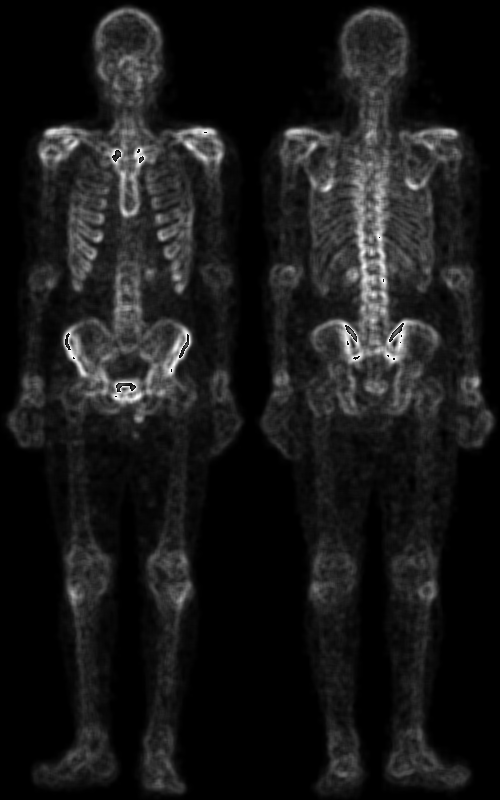

In [12]:
gradav = averagefiltering(gradar)
gradavim = converttoimage(gradav)
gradavim

In [13]:
def averageproductsharp(avr,shpar):
    filterar = np.zeros(avr.shape)
    padavr = np.zeros((avr.shape[0]+2, avr.shape[1]+2))
    padshpar = np.zeros((avr.shape[0]+2, avr.shape[1]+2))
    padavr[1:(padavr.shape[0]-1), 1:(padavr.shape[1]-1)] = avr
    padshpar[1:(padshpar.shape[0]-1), 1:(padshpar.shape[1]-1)] = shpar
    for i in range(filterar.shape[0]):
        for j in range(filterar.shape[1]):
            avrportion = padavr[i:i+3, j:j+3]
            shparportion = padshpar[i:i+3, j:j+3]
            filterar[i][j] = np.sum(np.multiply(avrportion, shparportion))
    return filterar

<h3>Taking the product of laplacian and average filter gives you a good result of its edges and can be add up with original image</h3>
<i>The array is the result of product so can have the value above 255 so we divide it up by 255</i>

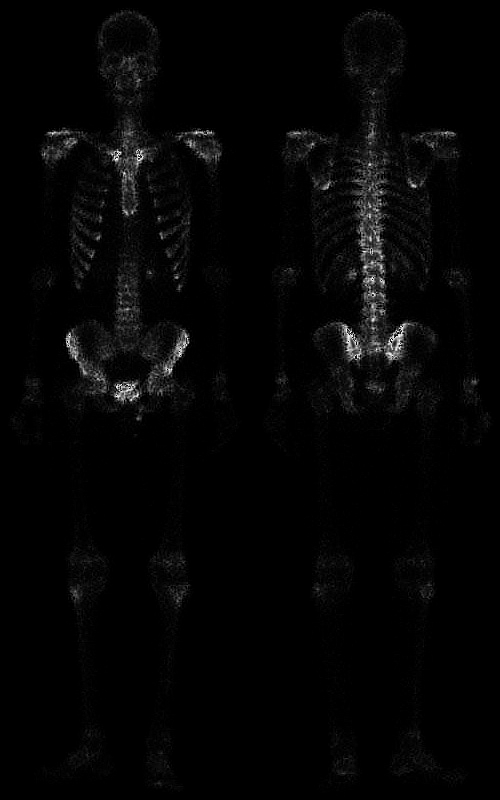

In [22]:
prodar = (gradav*lapsharpar)/255 #averageproductsharp(gradav,lapsharpar)
prodim = converttoimage(prodar)
prodim

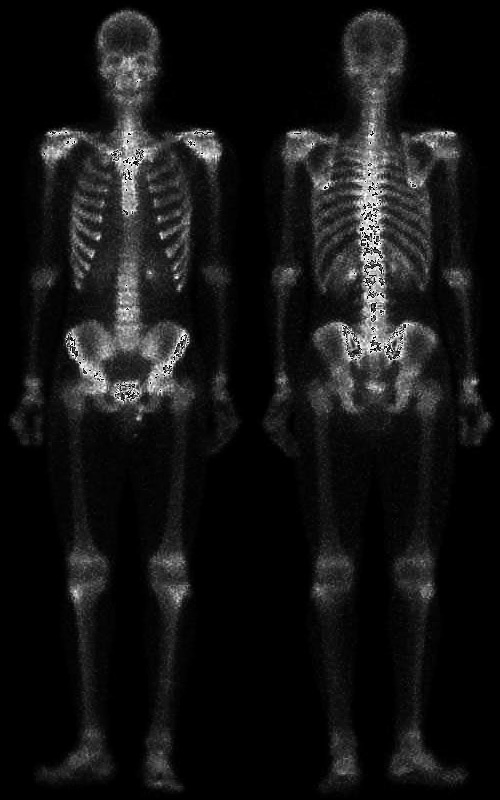

In [23]:
sharpar = prodar + org
sharpim = converttoimage(sharpar)
sharpim

<h3>Negative image transformation of power law transformation</h3>

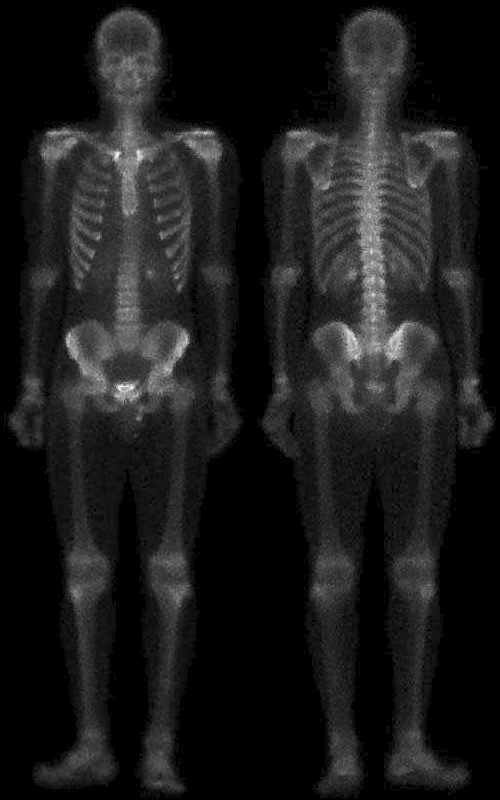

In [50]:
gamacorar = np.power(sharpar, 0.5)
gamacorar = (gamacorar - np.amin(gamacorar))/(np.amax(gamacorar) - np.amin(gamacorar)) * 255
gamacorim = converttoimage(gamacorar)
gamacorim.save("final_result.tif")
gamacorim

Text(0.5, 1.0, 'final enhancement')

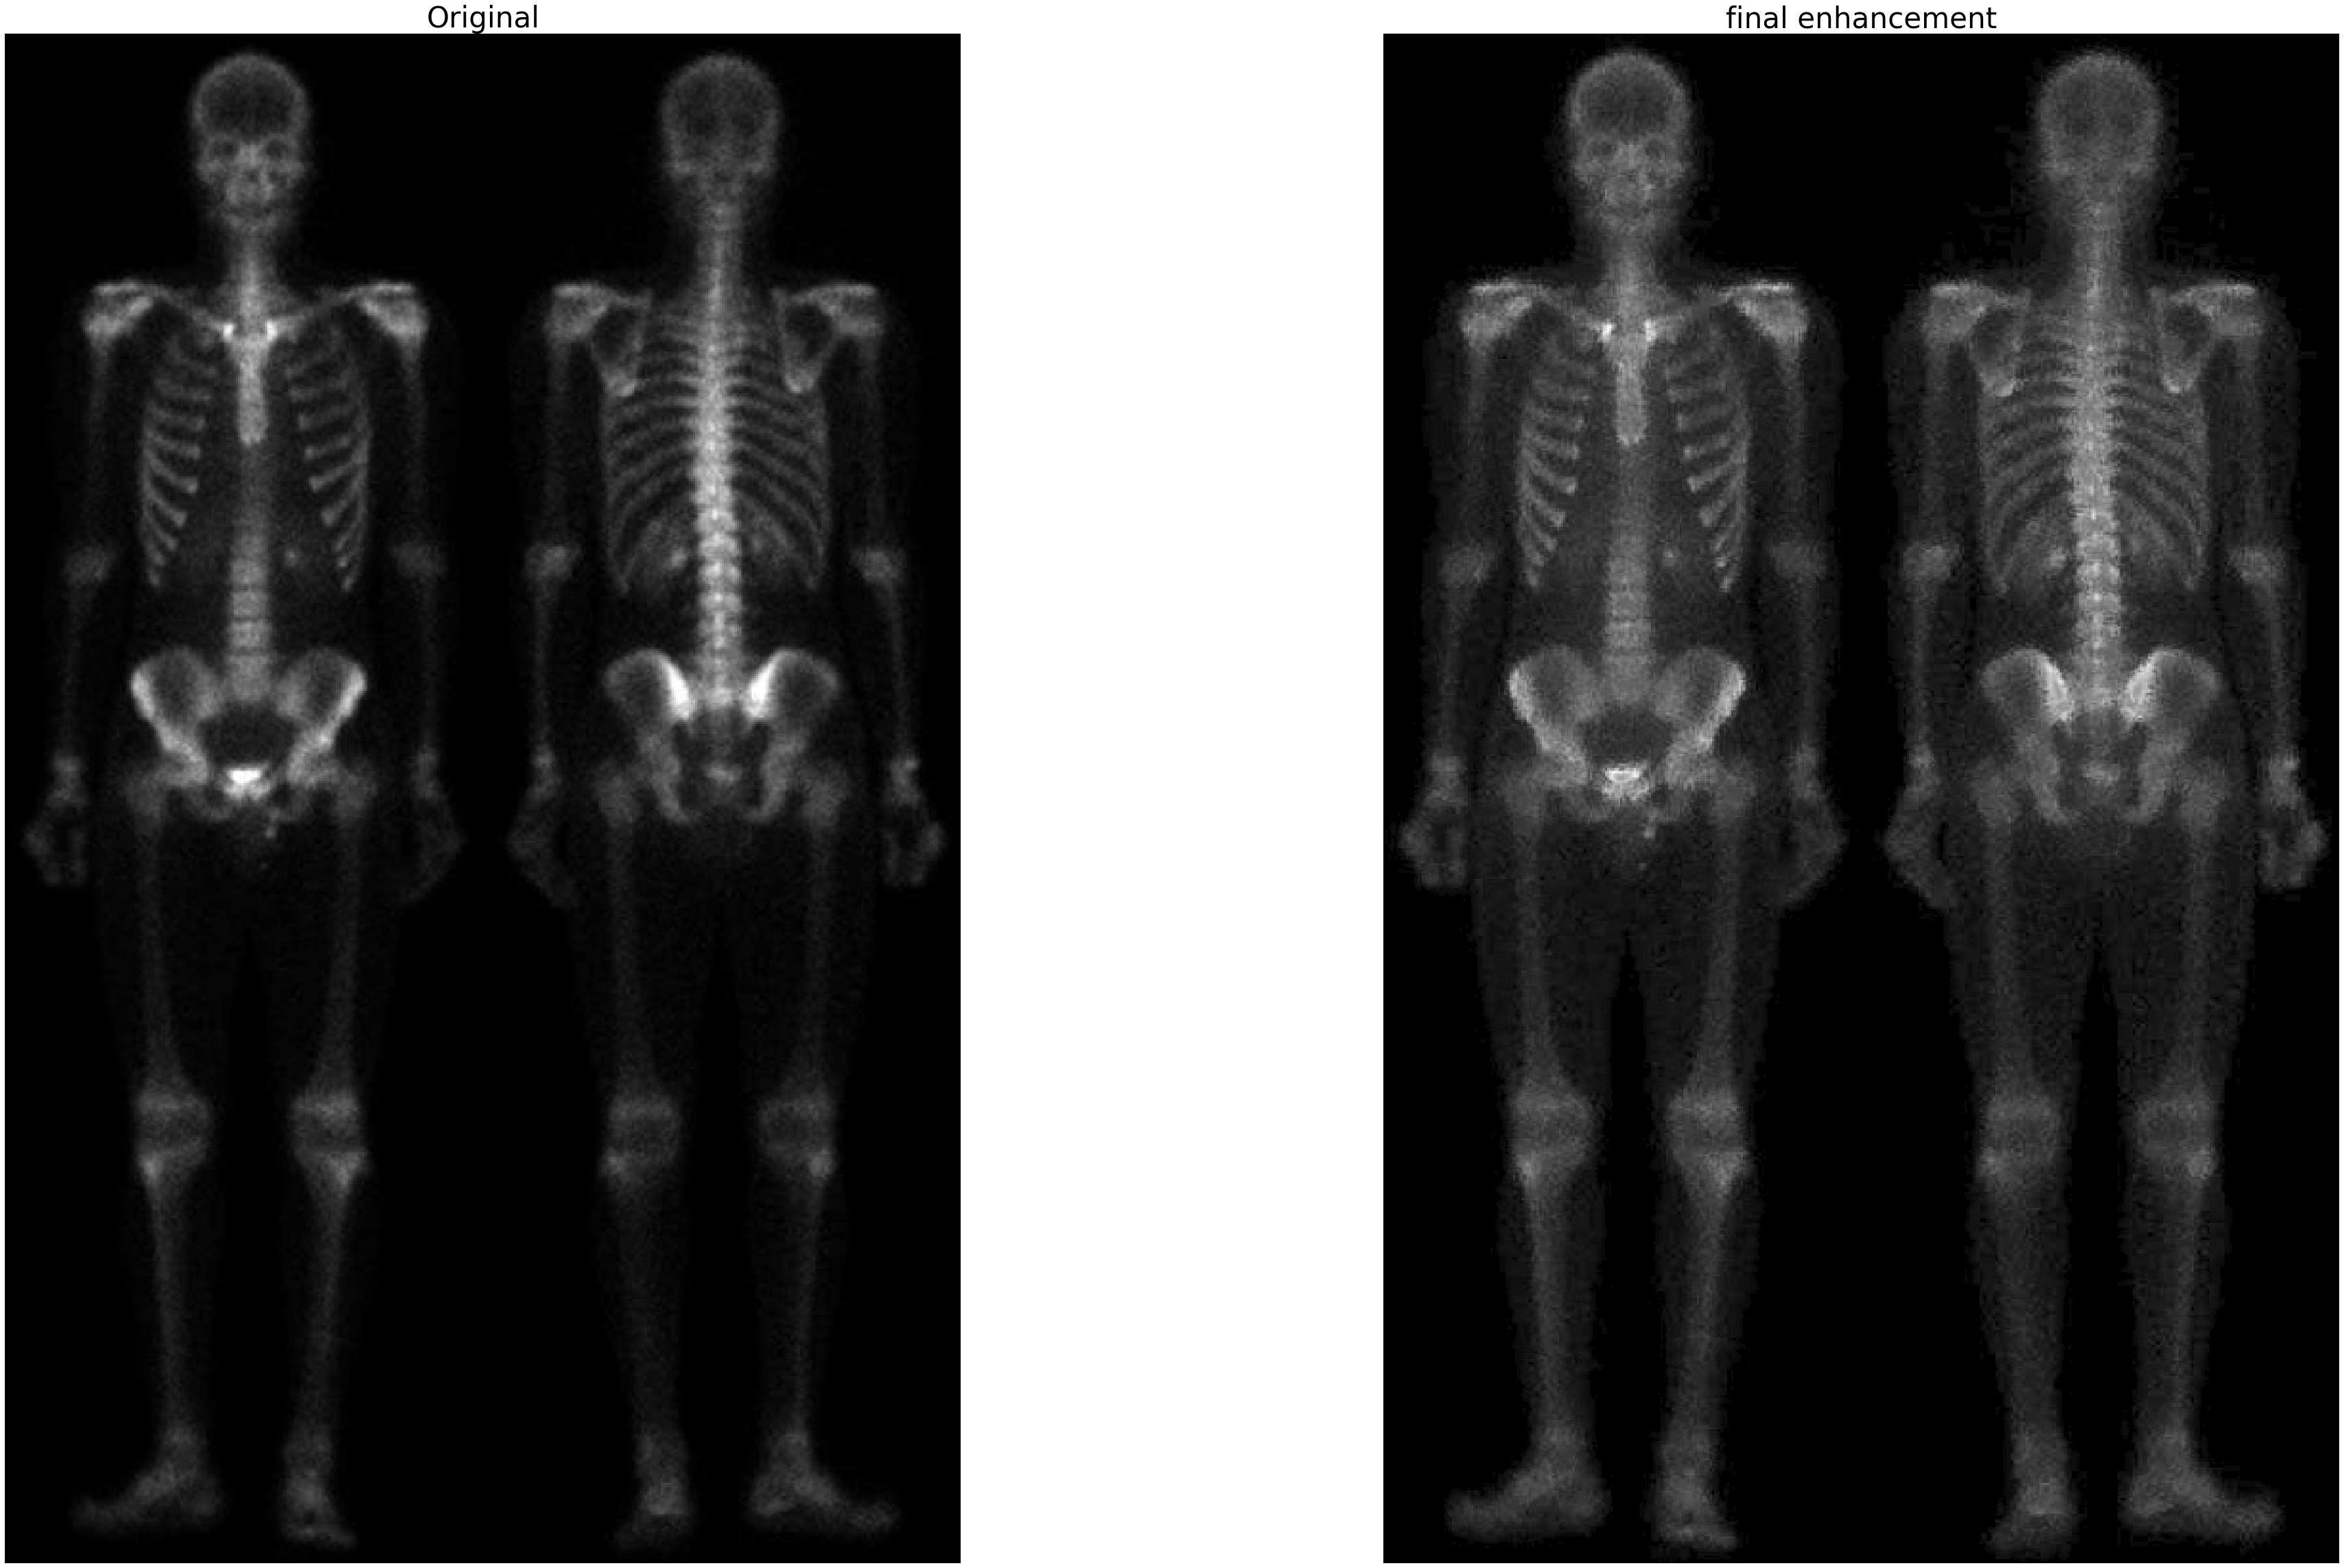

In [45]:
f = plt.figure(figsize=(org.shape[0]//12, org.shape[1]//12))
plt.rcParams.update({'font.size': 35})
f.add_subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap="gray", interpolation="nearest")
plt.title("Original")
f.add_subplot(1,2,2)
plt.axis('off')
plt.imshow(gamacorim, cmap="gray", interpolation="nearest")
plt.title("final enhancement")